Bishop et al: https://www.nature.com/articles/nphys1154

Qutip reference:

https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/rabi-oscillations.ipynb

https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/ultrastrong-coupling-groundstate.ipynb

http://qutip.org/docs/3.1.0/apidoc/functions.html

Koch 2007: https://arxiv.org/pdf/cond-mat/0703002.pdf

Bishop thesis: https://www.levbishop.org/thesis/Bishop-thesis.pdf

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, stats, integrate
from qutip import *
# Note to self: ^ IS NOT POWER, ** IS POWER

In [3]:
# h = 6.62607004*10**(-34)
hbar = 1 # NECESSARY TO MAKE SOLVER WORK
h = hbar*2*np.pi

# Unit conversions
# MHz = 10.0**6
# GHz = 10.0**9
# kHz = 10.0**3
# mus = 10.0**-6
# ns = 10.0**-9
MHz = 10.0**(-3)
GHz = 1.0 # NECESSARY TO MAKE SOLVER WORK
kHz = 10.0**(-6)
mus = 10.0**3
ns = 1.0

def dbtoxi(dB):
    return np.sqrt((10*MHz)**2*10**(dB/10)) # bishop thesis p. 87 for xi reference (5 MHz)
# print(dbtoxi(0))

# Transmon constants
EC_q = [400*MHz*h, 340*MHz*h]
EJ_init = 41.714285714285715*EC_q[0] # temporary, this will be defined later as bestEJ_1,2

# number of cavity states
# Nr = 3
Nr = 5
# number of transmon states
Nj = 2

# cavity/resonator frequency
wr = 2*np.pi*6.92*GHz
# drive frequency (from supplementary info)
wd = 2*np.pi*6.93*GHz

# transmon-resonator coupling strength
g0_q = [np.pi*347*MHz, np.pi*94.4*MHz]

# cavity dissipation rate
kappa = 2*np.pi*300*kHz
# transmon relaxation rate (2pi/T1)
T1_q = [1.7*mus, 1.4*mus]
gamma1_q = [1/T1_q[qNum] for qNum in [0,1]]
# transmon dephasing rate
gammaphi = 0.0


# for the TLS stuff
T1p_q = [2/(gamma1_q[qNum]+kappa) for qNum in [0,1]]
T2p_q = [4/(gamma1_q[qNum]+2*gammaphi+kappa) for qNum in [0,1]]

a = tensor(destroy(Nr), qeye(Nj)) # cavity op

In [4]:
# Transmon corrected energies from perturbation theory (Koch p. 19)
def getWj_full(EC, EJ):
    b = destroy(Nj) # pure SHO operators
    Hsho = np.sqrt(8*EC*EJ)*(b.dag()*b + 1/2)-EJ
    evals, ekets = Hsho.eigenstates()
    ECorrect = [evals[j] - EC/12*(6*j**2 + 6*j + 3) for j in range(Nj)]
    ECorrect = ECorrect - ECorrect[0] # adjust so that first level has 0 point energy
    return np.asarray(ECorrect)/hbar

print(getWj_full(EC_q[0], EJ_init)/(2*np.pi*GHz))
print(np.sqrt(8*EC_q[0]*EJ_init)/(2*np.pi*GHz))

def getWij_full(i, j, EC, EJ):
    wj = getWj_full(EC, EJ)
    return wj[j]-wj[i]

# Transmon states from perturbation theory (Koch p. 19)
def getJKets(qNum):
    EC = EC_q[qNum]
    EJ = EJ_q[qNum]
    b = destroy(Nj) # pure SHO operators
    Hsho = np.sqrt(8*EC*EJ)*(b.dag()*b + 1/2)-EJ
    evals, ekets = Hsho.eigenstates()
#     print(evals/hbar)
    ECorrect = [evals[j] - EC/12*(6*j**2 + 6*j + 3) for j in range(Nj)]
#     print("%.3e" % (ECorrect[0]/hbar))
#     print("alpha/EC: %.2f" % ((ECorrect[2]-ECorrect[1]-(ECorrect[1]-ECorrect[0]))/(hbar*EC)))
    jketsCorrect = np.copy(ekets)
    jkets1 = np.asarray([0*basis(Nj,0)]*Nj, dtype=object)
    for j in range(Nj):
        for i in range(Nj):
            if i == j: continue
            quartic = (b+b.dag())**4
            element = quartic.matrix_element(ekets[i], ekets[j])
            jkets1[j] += (element*ekets[i])/(ECorrect[i]-ECorrect[j])
        jkets1[j] *= -EC/12
    jketsCorrect += jkets1
    
    return jketsCorrect

# getJKets(EC, EJ)

[0.         6.90713937]
7.307139366009499


In [5]:
# also known as the nkets
def getPhotonKets():
    a = destroy(Nr)
    H = hbar*wr*a.dag()*a
    # need to include the drive term here??
    evals, ekets = H.eigenstates()
    return ekets

In [61]:
# JC with coherent drive (Bishop p. 1)

# def getHjcMeSolve(xi, wd, jkets, pN, qNum):
#     wj = getWj(qNum)
#     gj = g0_q[qNum] * np.asarray([np.sqrt(j+1) for j in range(Nj)])
#     Hjc_0 = hbar*wr*(a.dag()*a+1/2)
#     for j in range(Nj):
#         Hjc_0 += hbar*wj[j]*tensor(qeye(Nr), ket2dm(jkets[j]))
#     for j in range(Nj-1):
#         temp = a*tensor(qeye(Nr), jkets[j+1]*jkets[j].dag())
#         Hjc_0 += hbar*gj[j]*(temp + temp.dag())
#     Hjc_0 = pN*Hjc_0
    
#     # Break up Hjc into time independent, dependent to put into mesolve
#     # (See http://qutip.org/docs/latest/guide/dynamics/dynamics-time.html)
#     Hjc_1 = hbar*xi*a.dag()
#     Hjc_1 = pN*Hjc_1
#     Hjc_2 = hbar*xi*a
#     Hjc_2 = pN*Hjc_2
#     def Hjc1_time_dep(t, args):
#         return np.exp(-1j*wd*t)
#     def Hjc2_time_dep(t, args):
#         return np.exp(1j*wd*t)
    
#     Hjc = [Hjc_0, [Hjc_1, Hjc1_time_dep], [Hjc_2, Hjc2_time_dep]]
#     # Hjc = Hjc_0
#     # print(Hjc_0)
#     return Hjc

# Bishop thesis p. 42 for RWA on Hjc
def getHjcRWA(xi, wd, jkets, pN, qNum):
    wj = getWj(qNum)
    gj = g0_q[qNum] * np.asarray([np.sqrt(j+1) for j in range(Nj)])
    Hjc = hbar*(wr-wd)*(a.dag()*a+1/2)
    for j in range(Nj):
        Hjc += hbar*(wj[j]-j*wd)*tensor(qeye(Nr), ket2dm(jkets[j]))
    for j in range(Nj-1):
        temp = a*tensor(qeye(Nr), jkets[j+1]*jkets[j].dag())
        Hjc += hbar*gj[j]*(temp + temp.dag())
    Hjc += hbar*xi*a.dag() + hbar*xi*a
    return Hjc

# projection operator onto total n+j = N excitations
def projN(N, nkets, jkets):
    pN = 0*tensor(qeye(Nr), qeye(Nj))
    for n in range(Nr):
        for j in range(Nj):
            if n+j > N: continue
#             print(n,j)
            njKet = tensor(nkets[n], jkets[j])
            pN += ket2dm(njKet)
    return pN

### EJ calibration using B sweep

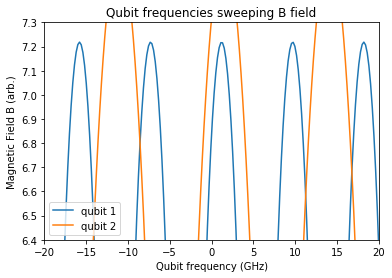

41.69868854665227


In [44]:
# Fig S8 in supplement to get EJ and B
# arb units for B

# Simple Josephson junction EJ calculation
def getEJ(B, EJ_max, C, phi):
    return EJ_max*np.abs(np.cos(C*(B-phi)))
arrB = np.linspace(-20, 20, num=200)

EJ_max_q = [EJ_init/0.92, EJ_init/0.72]
C_q = [0.37, 0.25]
EJphi_q = [1.2, 1.5]

arrW01_1 = []
arrW01_2 = []

for B in arrB:
    arrW01_1.append(getWij_full(0, 1, EC_q[0], getEJ(B, EJ_max_q[0], C_q[0], EJphi_q[0])))
    arrW01_2.append(getWij_full(0, 1, EC_q[1], getEJ(B, EJ_max_q[1], C_q[1], EJphi_q[1])))
arrW01_1 = np.asarray(arrW01_1)
arrW01_2 = np.asarray(arrW01_2)

plt.plot(arrB, arrW01_1/(2*np.pi*GHz), label = "qubit 1")
plt.plot(arrB, arrW01_2/(2*np.pi*GHz), label = "qubit 2")
plt.ylim(6.4, 7.3)
plt.xlim(-20, 20)
plt.legend()
plt.xlabel('Qubit frequency (GHz)')
plt.ylabel('Magnetic Field B (arb.)')
plt.title("Qubit frequencies sweeping B field")
plt.show()

bestEJ_q = [getEJ(8.6, EJ_max_q[0], C_q[0], EJphi_q[0]), getEJ(16.39, EJ_max_q[1], C_q[1], EJphi_q[1])]
EJ_q = bestEJ_q
print(EJ_q[0]/EC_q[0])

In [8]:
# simplified function for use later on
def getWj(qNum):
    return getWj_full(EC_q[qNum], EJ_q[qNum])
def getWij(i, j, qNum):
    return getWij_full(i, j, EC_q[qNum], EJ_q[qNum])

# TLS mapping:

(Figure 2 green lines)

In [9]:
def intensityTLS(xi, wd, qNum):
    g0 = g0_q[qNum]
    T1p = T1p_q[qNum]
    T2p = T2p_q[qNum]
    Omega = np.sqrt(2)*xi
    Delta = getWij(0, 1, qNum)-g0-wd
    numerator = T2p*Omega*np.sqrt((Delta**2*T2p**2 + 1)/2)
    denominator = Delta**2*T2p**2 + T1p*T2p*Omega**2 + 1
    return (numerator/denominator)**2/4 # A^2/A1^2

# analytical steady state dm for use in mesolve
def rhoSteady(xi, wd, qNum):
    g0 = g0_q[qNum]
    T1p = T1p_q[qNum]
    T2p = T2p_q[qNum]
    Omega = np.sqrt(2)*xi
    Delta = getWij(0, 1, qNum)-g0-wd
    x = -(Delta*T2p**2*Omega)/(1+Delta**2*T2p**2 + T1p*T2p*Omega**2)
    y = (T2p*Omega)/(1 + Delta**2*T2p**2 + T1p*T2p*Omega**2)
    z = -(1 + Delta**2*T2p**2)/(1 + Delta**2*T2p**2 + T1p*T2p*Omega**2)
    nkets = getPhotonKets()
    jkets = getJKets(qNum)
    down = tensor(nkets[0], jkets[0])
    up = (tensor(nkets[0], jkets[0]) - tensor(nkets[0], jkets[1]))/np.sqrt(2)
    Sigmax = up*down.dag() + down*up.dag()
    Sigmay = 1j*(-up*down.dag() + down*up.dag())
    Sigmaz = up*up.dag() - down*down.dag()
    rho = (tensor(qeye(Nr), qeye(Nj)) + x*Sigmax + y*Sigmay + z*Sigmaz)/2
    return rho

### [DEPRECATED] EJ calibration using TLS

In [10]:
# # get best EJ for qubit 1 from TLS
# def getBestEJ(EC, g0):
#     nPoints = 100
#     xData = np.linspace(6.5*GHz, 7.1*GHz, num = nPoints)
#     yData = []

#     # drive strength: expect supersplitting when strength>1
#     strength = 0.1
#     xi = (1/np.sqrt(2*T1p*T2p))*strength
#     # print(xi)

#     # Find the EJ that gets you closest to the one in the paper
#     EJtry = np.linspace(41*EC, 42*EC, num = 50)
#     bestEJ = 0
#     minDist = 1000*GHz
#     closestFreq = 0
#     for EJ in EJtry:
#         yData = []
#         for fd in xData:
#             yData.append(intensityTLS(xi, fd*2*np.pi, EC, EJ, g0))
#         peakI = np.max(yData)
#         peakFreqLoc = np.where(yData == peakI)[0][0]
#         peakFreq = xData[peakFreqLoc]
#         if np.abs(peakFreq - 6.734*GHz) < minDist:
#             bestEJ = EJ
#             closestFreq = peakFreq
#             minDist = np.abs(peakFreq - 6.734*GHz)
#     print(bestEJ/EC)
#     print(closestFreq/GHz)
#     return bestEJ

### Fig 2 green lines

Done with dB=0.0


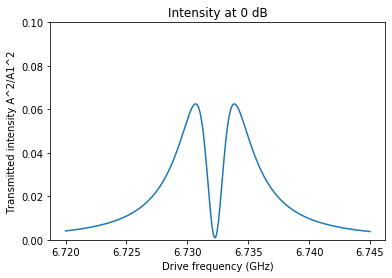

Done with dB=-10.0


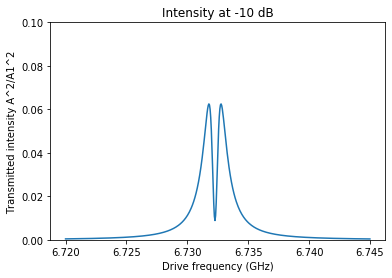

Done with dB=-20.0


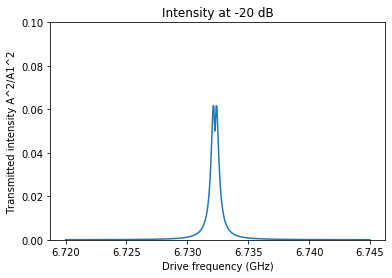

Done with dB=-30.0


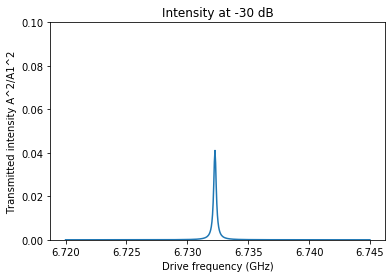

In [46]:
nPoints = 500
qNum = 0
xData = np.linspace(6.72*GHz, 6.745*GHz, num = nPoints)

# qNum = 1
# xData = np.linspace(6.86*GHz, 6.89*GHz, num = nPoints)
# xData = np.linspace(6.5*GHz, 7*GHz, num = nPoints)

EJ_q = bestEJ_q

# drive strength: expect supersplitting when strength>1
# for strength in [0.8, 1.7, 5, 20]:
#     xi = (1/np.sqrt(2*T1p_q[qNum]*T2p_q[qNum]))*strength

for dB in [0, -10, -20, -30]:
    xi = dbtoxi(dB)
    fig2TLSYData = []
    for i, fd in enumerate(xData):
#         if i % 100 == 0:
#             print("%d of %d done" % (i, nPoints))
        fig2TLSYData.append(intensityTLS(xi, fd*2*np.pi, qNum))
    print("Done with dB=%.1f" % dB)
    
    plt.plot(xData, fig2TLSYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
    plt.ylim(0, 0.1)
    plt.title("Intensity at %d dB" % dB)
    plt.show()

# Master eqn solver:

(Figure 2 black lines)

In [75]:
# charge dispersion (from Koch eq. 2.5)
def betaj(qNum):
    EC = EC_q[qNum]
    EJ = EJ_q[qNum]
    epj = [((-1)**m * EC * 2**(4*m+5)/(np.math.factorial(m)) * \
        np.sqrt(2/np.pi) * (EJ/(2*EC))**(m/2+3/4) * \
        np.exp(-np.sqrt(8*EJ/EC))) \
       for m in range(Nj)]
    return 2*epj/(epj[1]-epj[0])

# Get the steady state intensity
def intensity(xi, wd, qNum):
    jkets = getJKets(qNum)
    nkets = getPhotonKets()
    # truncate to N = 7 Hilbert space
    pN = projN(7, nkets, jkets)
#     print(pN)
#     pN = tensor(qeye(Nr), qeye(Nj))
    
    # Damping terms
    c_ops = []
    c_ops.append(kappa*lindblad_dissipator(a))
    
    
    # relative strengths of damping
    g0 = g0_q[qNum]
    gj = g0 * np.asarray([np.sqrt(j+1) for j in range(Nj)])
    alphaj = gj/g0
    temp = 0*tensor(qeye(Nr), qeye(Nj))
    for j in range(Nj-1):
        temp += alphaj[j]*jkets[j].dag()*jkets[j+1]
    c_ops.append(gamma1_q[qNum]*lindblad_dissipator(temp))
    
    temp = 0*tensor(qeye(Nr), qeye(Nj))
    for j in range(Nj-1):
        temp += betaj(qNum)[j]*jkets[j].dag()*jkets[j]
    c_ops.append(gammaphi/2*lindblad_dissipator(temp))
    
    Hjc = getHjcRWA(xi, wd, jkets, pN, qNum)
    
    # Bishop Eq. 2 (steady state transmission amp)
    
    # Output from tr(a*rho_s)
    rho_ss = steadystate(Hjc, c_ops)
    expect_a = (a*rho_ss).tr()
    intensity_t = np.abs(expect_a)**2 # A^2/A1^2
    return intensity_t

# print(intensity(xi, wd, EC, EJ))

### Fig 2 black lines

Done with dB=0.0


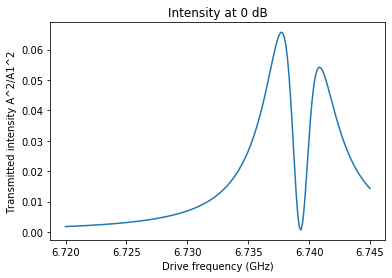

Done with dB=-10.0


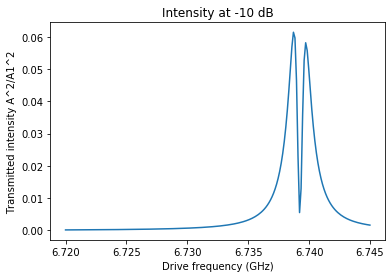

Done with dB=-20.0


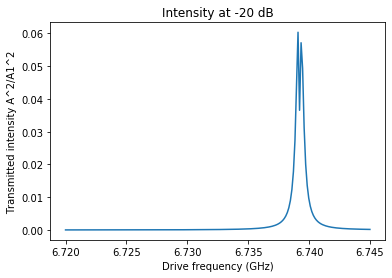

Done with dB=-30.0


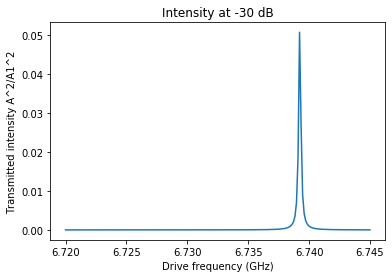

In [83]:
nPoints = 200
xData = np.linspace(6.72*GHz, 6.745*GHz, num = nPoints)
# xData = np.linspace(6.72*GHz, 7.05*GHz, num = nPoints)
fig2FullYData = []

qNum = 0
EJ_q = bestEJ_q

for dB in [0, -10, -20, -30]:
# for dB in [0]:
    xi = dbtoxi(dB)
    fig2FullYData = []
    for i, fd in enumerate(xData):
#         if i % 10 == 0:
#             print("%d of %d done" % (i, nPoints))
#         print("%d of %d done" % (i, nPoints))
        try:
            fig2FullYData.append(intensity(xi, fd*2*np.pi, qNum))
        except:
            fig2FullYData.append(fig2FullYData[len(fig2FullYData)-1])
            print("Solver failed on fd %f" % fd)
            
    print("Done with dB=%.1f" % dB)
    
    plt.plot(xData, fig2FullYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
#     plt.ylim(0, 0.1)
    plt.title("Intensity at %d dB" % dB)
    plt.show()

### Fig 3 (uses qubit 2)

Done with dB=2.0


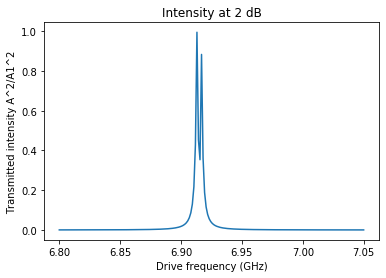

In [ ]:
nPoints = 200
xData = np.linspace(6.80*GHz, 7.05*GHz, num = nPoints)

qNum = 1
EJ_q = bestEJ_q

fig3FullYData = []
for dB in [2, 0, -5]:
# for dB in [0]:
    xi = dbtoxi(dB)
    fig3FullYData = []
    for i, fd in enumerate(xData):
#         if i % 50 == 0:
#             print("%d of %d done" % (i, nPoints))
#         print("%d of %d done" % (i, nPoints))
        try:
            fig3FullYData.append(intensity(xi, fd*2*np.pi, qNum))
        except:
            fig3FullYData.append(fig3FullYData[len(fig3FullYData)-1])
    print("Done with dB=%.1f" % dB)
    
    plt.plot(xData, fig3FullYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
#     plt.ylim(0, 0.1)
    plt.title("Intensity at %d dB" % dB)
    plt.show()

### Fig 4 (uses qubit 2)

In [ ]:
nPoints = 200
xData = np.linspace(6.80*GHz, 7.05*GHz, num = nPoints)

qNum = 1
dB = 1
xi = dbtoxi(dB)

fig4FullYData = []
for B in [15.507, 15.403]:
# for B in [15.507]:
    fig4FullYData = []
    
    EJ_q[qNum] = getEJ(B, EJ_max_q[qNum], C_q[qNum], EJphi_q[qNum])
    for i, fd in enumerate(xData):
#         if i % 50 == 0:
#             print("%d of %d done" % (i, nPoints))
#         print("%d of %d done" % (i, nPoints))
        try:
            fig4FullYData.append(intensity(xi, fd*2*np.pi, qNum))
        except:
            fig4FullYData.append(fig4FullYData[len(fig4FullYData)-1])
    print("Done with dB=%.1f" % dB)
    
    plt.plot(xData, fig4FullYData)
    plt.xlabel('Drive frequency (GHz)')
    plt.ylabel('Transmitted intensity A^2/A1^2')
#     plt.ylim(0, 0.1)
    plt.title("Intensity at B = %.3f" % B)
    plt.show()